In [2]:
using StatsPlots, Plots, DelimitedFiles,LaTeXStrings


# Formatting Plots

The cell below provides the settings we use to style our plots. The cell should only be run a single time otherwise the fontsize will keep increasing.

In [3]:

scalefontsizes(1.3) 
plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=1, framestyle=:box, label=nothing, grid=false, alpha = 0.6)


# Input Data

In [21]:
#Input data

asset_quantity = readdlm("data/sample_asset_quantity.csv", ',', Float64);
asset_tiers = readdlm("data/sample_asset_tiers.csv", ',', Float64);
asset_value = readdlm("data/sample_asset_value.csv", ',', Float64);

account_exposure = readdlm("data/sample_account_exposure.csv", ',', Float64);
account_durations = readdlm("data/sample_account_duration.csv", ',', Float64);


single_limits = readdlm("data/sample_single_limits.csv", ',', Float64);
haircuts = readdlm("data/sample_haircuts.csv", ',', Float64)/100;




10×5 Matrix{Float64}:
 0.9   0.909091  0.909091  0.943396  0.9
 1.0   1.0       0.909091  0.900901  1.0
 1.0   1.0       1.0       1.0       1.0
 1.0   0.909091  0.909091  0.900901  1.0
 0.9   0.934579  0.909091  0.943396  0.9
 0.9   0.909091  0.909091  0.943396  0.9
 0.95  1.0       0.980392  1.0       0.95
 0.95  1.0       0.980392  1.0       0.95
 0.95  1.0       1.0       1.0       0.95
 0.95  0.952381  0.980392  0.952381  0.95

In [5]:
# Auxillary variables 

tier_set = [0.2, 0.5, 0.8] 

n_assets = length(asset_tiers)

n_accounts = length(account_durations)

cost_factor_matrix = Array{Float64}(undef, length(asset_tiers), length(account_durations))

for i in 1:n_assets
    for j in 1:n_accounts
        cost_factor_matrix[i,j] = abs(asset_tiers[i] - account_durations[j])
    end
end

cost_factor_matrix = round.(cost_factor_matrix, digits = 2);

# Utilities 

In [6]:
function ObjectiveFunction(Q)
    obj = 0
    for i in 1:n_assets
        for j in 1:n_accounts
            obj += cost_factor_matrix[i,j]*Q[i,j]
        end
    end
    return obj
end

ObjectiveFunction (generic function with 1 method)

In [7]:
function FractionalQuantityBarChart(Q)
 

data_for_plot_long = zeros(n_assets)
data_for_plot_short = zeros(n_assets)

data_for_plot_combined = zeros(n_assets*2)



for i in 1:n_assets
    for j in 1:n_accounts
        if account_durations[j] == 1
            data_for_plot_short[i] += Q[i,j]
        else
            data_for_plot_long[i] += Q[i,j]
        end
    end
end

        
data_for_plot_combined = [data_for_plot_long ; data_for_plot_short]
println(data_for_plot_combined)

x_axis_str = repeat(1:10, outer=2)
duration = repeat(["Long Term", "Short term"], inner=10)

groupedbar(x_axis_str, data_for_plot_combined, xlabel = "Asset ID", 
    ylabel=" Assets Posted (Fractional Quantity)", group = duration,  grid=false, xrotation=90, xticks= 1:10, label = false)
end

FractionalQuantityBarChart (generic function with 1 method)

In [8]:
function Overheads(Q)

value_posted_to_account = Array{Float64}(undef, length(account_durations))

relative_value_posted_to_exposure = Array{Float64}(undef, length(account_durations))

for j in 1:n_accounts
    current = 0
    for i in 1:n_assets
        current += Q[i,j] * asset_quantity[i] * asset_value[i] *haircuts[i,j]
    end
    value_posted_to_account[j] = current
    relative_value_posted_to_exposure[j] = round(value_posted_to_account[j]/account_exposure[j], digits = 4)
end


    return relative_value_posted_to_exposure
    
end


Overheads (generic function with 1 method)

# Classical Solver 

The solution produced by the HiGHS simplex solver


[0.0, 0.7941510158145388, 0.0, 0.0, 0.04717413067284134, 0.10912747040397108, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18731708267572655, 0.028428519582867906, 0.0, 0.6485850323224743, 0.0, 0.0]


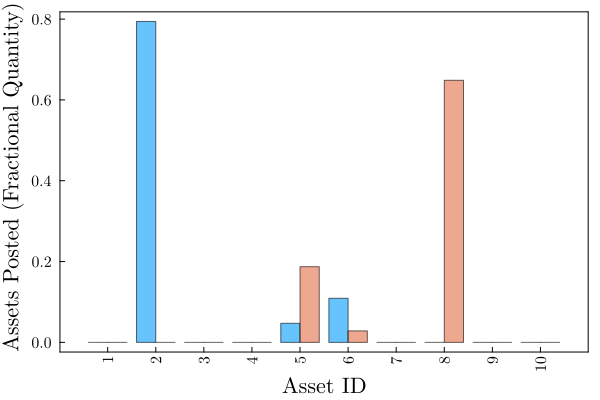

In [9]:
#may need to replace filename appropriately
Q_values_HiGHS_simplex = readdlm("Q_values_HiGHS_simplex_single_limits.csv", ',', Float64)
FractionalQuantityBarChart(Q_values_HiGHS_simplex)


In [10]:
println(ObjectiveFunction(Q_values_HiGHS_simplex))

0.4745708112951061


# Balanced QUBO Approaches

### D-Wave simulated Annealer

[0.11023622047244094, 0.6141732283464567, 0.0, 0.49606299212598426, 0.09448818897637795, 0.05511811023622047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023622047244094488, 0.0, 0.0, 0.2598425196850394, 0.007874015748031496, 0.0, 0.5039370078740157, 0.08661417322834646, 0.0]


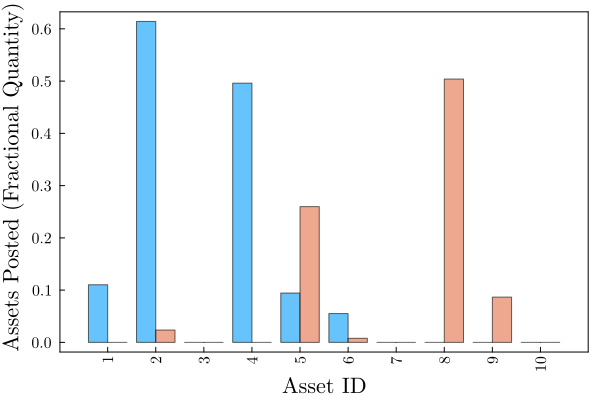

In [11]:
#may need to replace filename appropriately
Q_values_balanced_pyqubo = readdlm("Q_value_balanced_py_qubo_single_limit.csv", ',', Float64)
FractionalQuantityBarChart(Q_values_balanced_pyqubo)


In [12]:
println(ObjectiveFunction(Q_values_balanced_pyqubo))

0.589763779527559

### Fujitsu DA

[0.4330708661417323, 0.33070866141732286, 0.0, 0.33070866141732286, 0.1732283464566929, 0.05511811023622047, 0.0, 0.1889763779527559, 0.0, 0.0, 0.0, 0.06299212598425197, 0.0, 0.0, 0.30708661417322836, 0.015748031496062992, 0.0, 0.2913385826771654, 0.007874015748031496, 0.0]


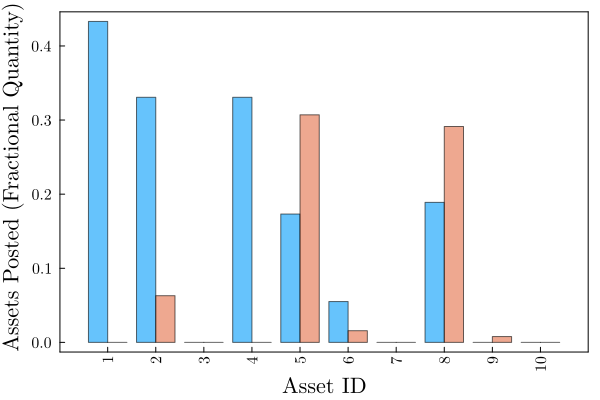

In [13]:
#may need to replace filename appropriately
Q_values_balanced_fujitsu = readdlm("Q_value_balanced_fujitsu_single_limit.csv", ',', Float64)
FractionalQuantityBarChart(Q_values_balanced_fujitsu)


In [14]:
println(ObjectiveFunction(Q_values_balanced_fujitsu))

0.7559055118110236


# Unbalanced QUBO Approaches

### D-Wave Simulated Annealer

[0.0, 0.6141732283464567, 0.0, 0.12598425196850394, 0.25984251968503935, 0.007874015748031496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25196850393700787, 0.015748031496062992, 0.0, 0.5433070866141733, 0.0, 0.0]


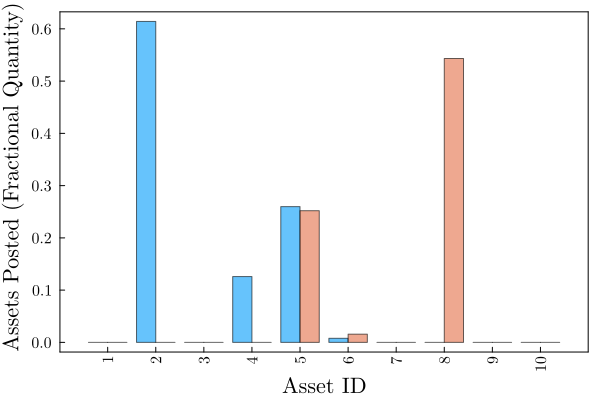

In [15]:
#may need to replace filename appropriately
Q_values_unbalanced_pyqubo = readdlm("Q_value_unbalanced_py_qubo_single_limit.csv", ',', Float64)  
FractionalQuantityBarChart(Q_values_unbalanced_pyqubo)


In [16]:
println(ObjectiveFunction(Q_values_unbalanced_pyqubo))

0.5244094488188977


### Fujitsu DA

[0.0, 0.4645669291338583, 0.0, 0.2125984251968504, 0.30708661417322836, 0.03937007874015748, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07086614173228346, 0.0, 0.0, 0.22834645669291337, 0.015748031496062992, 0.0, 0.4645669291338583, 0.0, 0.0]


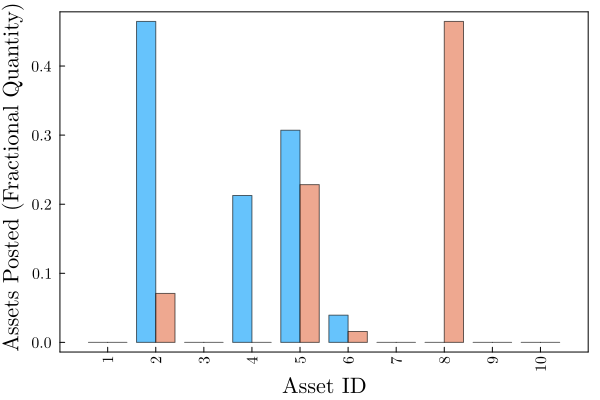

In [17]:
#may need to replace filename appropriately
Q_values_unbalanced_fujitsu = readdlm("Q_value_unbalanced_fujitsu_single_limit.csv", ',', Float64)
FractionalQuantityBarChart(Q_values_unbalanced_fujitsu)


In [18]:
println(ObjectiveFunction(Q_values_unbalanced_fujitsu))

0.5803149606299212


# Exposure graphs


In [19]:
overhead_HiGHS = Overheads(Q_values_HiGHS_simplex) - ones(n_accounts);
overhead_balanced_pyqubo = Overheads(Q_values_balanced_pyqubo) - ones(n_accounts);
overhead_unbalanced_pyqubo = Overheads(Q_values_unbalanced_pyqubo) - ones(n_accounts);
overhead_balanced_fujitsu = Overheads(Q_values_balanced_fujitsu) - ones(n_accounts);
overhead_unbalanced_fujitsu = Overheads(Q_values_unbalanced_fujitsu) - ones(n_accounts);

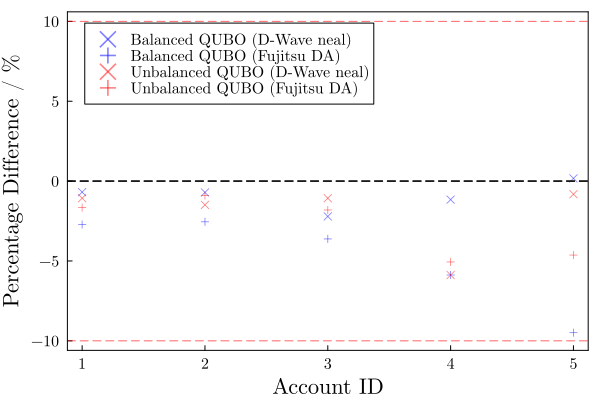

In [20]:

scatter((1:1:n_accounts, [overhead_balanced_pyqubo*100]),
 label = "Balanced QUBO (D-Wave neal)",
 legend =:topleft,
 alpha = 0.5, 
#  markerstrokewidth=0,
 marker = :x,
 markercolor =:blue

)

scatter!((1:1:n_accounts, [overhead_balanced_fujitsu*100 ]),
 label = "Balanced QUBO (Fujitsu DA)",
 legend =:topleft,
 alpha = 0.5, 
#  markerstrokewidth=0,
 marker = :plus,
 markercolor =:blue

)

scatter!((1:1:n_accounts, [overhead_unbalanced_pyqubo*100]),
label = "Unbalanced QUBO (D-Wave neal)",
legend =:topleft,
alpha = 0.5, 
# markerstrokewidth=0,
marker = :x,
markercolor=:red
)

scatter!((1:1:n_accounts, [overhead_unbalanced_fujitsu*100]),
label = "Unbalanced QUBO (Fujitsu DA)",
legend =:topleft,
alpha = 0.5, 
# markerstrokewidth=0,
marker = :plus,
markercolor=:red
)


ylabel!("Percentage Difference / %")
xlabel!("Account ID")
hline!([overhead_HiGHS], color="black", linestyle=:dash)
hline!([-10 10], color="red", linestyle=:dash) #error margin

